<a href="https://colab.research.google.com/github/md-marop-hossain/Ocular-Disease-Recognition-Project-CSE499A/blob/main/Ocular_Disease_Reconization_Using_CNN_Models_ResNet101_code%26_Resnet_152_%26_Dense_169_%2B_VGG19_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install kaggle
from google.colab import files
files.upload()
#create a kaggle folder
! mkdir ~/.kaggle
#copy the kaggle .josn to folder created
! cp kaggle.json ~/.kaggle/
#permission for the json the act
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
! unzip ocular-disease-recognition-odir5k

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [5]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## **ResNet-101**

0    6102
1     290
Name: right_cataract, dtype: int64
['0_left.jpg' '81_left.jpg' '103_left.jpg' '119_left.jpg' '254_left.jpg'
 '294_left.jpg' '330_left.jpg' '448_left.jpg' '465_left.jpg'
 '477_left.jpg']
['24_right.jpg' '81_right.jpg' '112_right.jpg' '188_right.jpg'
 '218_right.jpg' '345_right.jpg' '354_right.jpg' '477_right.jpg'
 '553_right.jpg' '560_right.jpg' '625_right.jpg' '726_right.jpg'
 '769_right.jpg' '949_right.jpg' '955_right.jpg']
Number of images in left cataract: 304
Number of images in right cataract: 290
594 600


100%|██████████| 594/594 [00:02<00:00, 246.39it/s]


588


100%|██████████| 600/600 [00:02<00:00, 239.84it/s]


1188


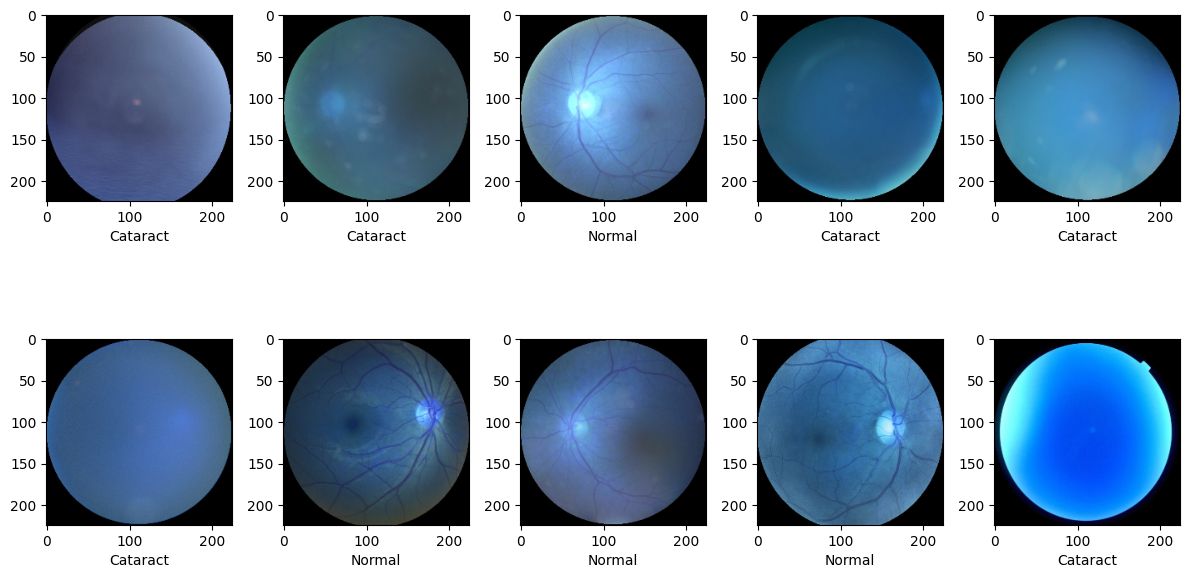

In [6]:
# Set random seed for reproducibility
random.seed(42)

# Read the CSV file
df = pd.read_csv("/content/full_df.csv")

# Define a function to check if a keyword contains "cataract"
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

# Create new columns for left and right cataract
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

# Print the count of right cataract samples
print(df.right_cataract.value_counts())

# Get the filenames of left and right cataract images
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

# Print the first few filenames
print(left_cataract[:10])
print(right_cataract[:15])

# Print the number of images in left and right cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

# Get a sample of normal fundus images for both left and right eyes
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state=42).values
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state=42).values

# Concatenate cataract and normal filenames
cataract = np.concatenate((left_cataract, right_cataract), axis=0)
normal = np.concatenate((left_normal, right_normal), axis=0)

# Print the number of cataract and normal images
print(len(cataract), len(normal))

# Define the dataset directory and image size
dataset_dir = "/content/preprocessed_images"
image_size = 224

# Create an empty list for storing image data and labels
dataset = []

# Function to create the dataset
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue

        dataset.append([np.array(image), np.array(label)])

    random.shuffle(dataset)
    return dataset

# Create the cataract dataset
dataset = create_dataset(cataract, 1)

# Print the length of the cataract dataset
print(len(dataset))

# Create the normal dataset
dataset = create_dataset(normal, 0)

# Print the length of the normal dataset
print(len(dataset))

# Plot a sample of images from the dataset
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    label = "Normal" if category == 0 else "Cataract"
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

# Split the dataset into features (x) and labels (y)
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Load the pre-trained ResNet-101 model
from tensorflow.keras.applications import ResNet101

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.save("model_name.h5")

from tensorflow.keras.models import load_model
resnet = load_model('model_name.h5')

# Create a new model based on ResNet-101
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test), callbacks=[early_stopping])

171446536/171446536 [==============================] - 9s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 68,348,801
Trainable params: 68,243,457
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/20
30/30 [====================